In [1]:
%%capture
# Add packages installation code

# source - https://www.kaggle.com/code/bunny11/store-sales-forecasting-by-gurpreetsingh
# https://www.kaggle.com/code/csmohamedayman/store-sales-time-series-forecasting#Baseline-Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, \
                                    median_absolute_error, max_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv("./store-sales-time-series-forecasting/train.csv")
test_data = pd.read_csv("./store-sales-time-series-forecasting/test.csv")
holidays = pd.read_csv("./store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("./store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("./store-sales-time-series-forecasting/transactions.csv")

In [4]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
print(f"Date range of the train data are from - {train_data.loc[:,'date'][0]} to {train_data.loc[:,'date'][len(train_data) - 1]}")

Date range of the train data are from - 2013-01-01 to 2017-08-15


In [11]:
train_data.drop(columns = ['id'], inplace=True)

In [12]:
# train_data['date'] = pd.to_datetime(train_data['date'], format = "%Y-%m-%d")

### EDA - Data Preprocessing

In [13]:
print(f'train_data.shape   : {train_data.shape}')
print(f'test_data.shape    : {test_data.shape}')
print(f'oil.shape          : {oil.shape}')
print(f'holidays.shape     : {holidays.shape}')
print(f'stores.shape       : {stores.shape}')
print(f'transactions.shape : {transactions.shape}')

train_data.shape   : (3000888, 5)
test_data.shape    : (28512, 5)
oil.shape          : (1218, 2)
holidays.shape     : (350, 6)
stores.shape       : (54, 5)
transactions.shape : (83488, 3)


In [14]:
train_data = train_data.merge(oil, on = "date", how = "left")
train_data = train_data.merge(holidays, on = "date", how = "left")
train_data = train_data.merge(stores, on = "store_nbr", how = "left")
train_data = train_data.merge(transactions, on = ["date", "store_nbr"], how = "left")

In [15]:
test_data = test_data.merge(oil, on = "date", how = "left")
test_data = test_data.merge(holidays, on = "date", how = "left")
test_data = test_data.merge(stores, on = "store_nbr", how = "left")
test_data = test_data.merge(transactions, on = ["date", "store_nbr"], how = "left")

In [16]:
target_feat = list(set(train_data.columns)-set(test_data.columns))[0]

In [17]:
def df_dtypes(df):
    df_dtypes = df.columns.groupby(df.dtypes)
    df_dtypes = pd.DataFrame({
        'dtype':     list(df_dtypes.keys()),
        'Number of columns': [len(df_dtypes[key])  for key in df_dtypes.keys()],
        'columns':   [list(df_dtypes[key]) for key in df_dtypes.keys()],
    })
    df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])

    return df_dtypes

In [18]:
df_dtypes(train_data)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,3,"['sales', 'dcoilwtico', 'transactions']"
2,object,10,"['date', 'family', 'type_x', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'type_y']"


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   dcoilwtico    float64
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  city          object 
 12  state         object 
 13  type_y        object 
 14  cluster       int64  
 15  transactions  float64
dtypes: float64(3), int64(3), object(10)
memory usage: 372.8+ MB


In [20]:
# building custom data info table using custom defined functions
def get_dtype(df):
    return [df[col].dtype for col in df.columns]

def get_count(df):
    return [df[col].count() for col in df.columns]

def get_mean(df, feat):
    return [round(df[col].mean(), 1) if col in feat else "" for col in df.columns]

def get_std(df, feat):
    return [round(df[col].std(), 1) if col in feat else "" for col in df.columns]

def get_min(df, feat):
    return [round(df[col].min(), 1) if col in feat else "" for col in df.columns]

def get_max(df, feat):
    return [round(df[col].max(), 1) if col in feat else "" for col in df.columns]

def get_quantile(df, feat, perc):
    return [round(df[col].quantile(perc), 1) if col in feat else "" for col in df.columns]

def get_IQR(df, feat):
    return [round(df[col].max() - df[col].min(), 1) if col in feat else "" for col in df.columns]

def get_nunique(df):
    return [df[col].nunique() for col in df.columns]

def get_unique(df, threshold):
    return [df[col].unique()  if df[col].nunique() < threshold else '' for col in df.columns]

def get_mode(df):
    return [df[col].mode()[0] if len(df[col].mode()) else "" for col in df.columns]

def get_mode_count(df):
    return [df[col].value_counts().max() for col in df.columns]

def get_mode_percentage(df):
    return [round(df[col].value_counts().max() * 100 / df.shape[0], 1) for col in df.columns]

def get_null_count(df):
    return [df[col].isnull().sum() for col in df.columns]

def get_null_percentage(df):
    return [round(df[col].isnull().mean() * 100, 1) for col in df.columns]

In [21]:
def build_my_info_table(df, nunique_threshold=35):
    numerical_features = df.select_dtypes(include=[np.number])
    df_info = pd.DataFrame({
        'column':   df.columns,
        'dtype':    get_dtype(df),
        'count':    get_count(df),
        'mean':     get_mean(df, numerical_features),
        'std':      get_std(df, numerical_features),
        'min':      get_min(df, numerical_features),
        '25%':      get_quantile(df, numerical_features, .25),
        '50%':      get_quantile(df, numerical_features, .5),
        '75%':      get_quantile(df, numerical_features, .75),
        'max':      get_max(df, numerical_features),
        'IQR':      get_IQR(df, numerical_features),
        'nunique':  get_nunique(df),
        'unique':   get_unique(df, nunique_threshold),
        'mode':     get_mode(df),
        'mode #':   get_mode_count(df),
        'mode %':   get_mode_percentage(df),
        'null #':   get_null_count(df),
        'null %':   get_null_percentage(df),
    })
    df_info = df_info.sort_values(by='dtype')
    return df_info

In [22]:
build_my_info_table(train_data)

,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
1,store_nbr,int64,3054348,27.5,15.6,1,14.0,27.5,41.0,54,53,54,,1,56562,1.9,0,0.0
4,onpromotion,int64,3054348,2.6,12.3,0,0.0,0.0,0.0,741,741,362,,0,2428528,79.5,0,0.0
14,cluster,int64,3054348,8.5,4.6,1,4.0,8.5,13.0,17,16,17,"[13, 15, 6, 7, 3, 12, 16, 9, 1, 10, 8, 2, 4, 5...",3,395934,13.0,0,0.0
3,sales,float64,3054348,359.0,1107.3,0.0,0.0,11.0,196.0,124717.0,124717.0,379610,,0.0,953741,31.2,0,0.0
5,dcoilwtico,float64,2099196,68.0,25.7,26.2,46.4,53.4,95.8,110.6,84.4,994,,46.02,7128,0.2,955152,31.3
15,transactions,float64,2805231,1697.1,966.8,5.0,1046.0,1395.0,2081.0,8359.0,8354.0,4993,,1207.0,2970,0.1,249117,8.2
0,date,object,3054348,,,,,,,,,1684,,2014-06-25,7128,0.2,0,0.0
2,family,object,3054348,,,,,,,,,33,"[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...",AUTOMOTIVE,92556,3.0,0,0.0
6,type_x,object,502524,,,,,,,,,6,"[Holiday, nan, Work Day, Additional, Event, Tr...",Holiday,304722,10.0,2551824,83.5
7,locale,object,502524,,,,,,,,,3,"[National, nan, Local, Regional]",National,261954,8.6,2551824,83.5


In [23]:
def plot_bar_chart(df, x, y, xlabel, ylabel, title, xmin=None, xmax=None, palette="muted"):
    if df.shape[0] == 0:
        return
    size = (12, df.shape[0] / 4 + 1)
    plt.figure(figsize=size)
    sns.barplot(y=df[y], x=df[x], palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not xmin and not xmax:
        xmin, xmax = df[x].min(), df[x].max()
        xrange = (xmax - xmin) * .1
        xmin, xmax = xmin-xrange, xmax+xrange
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()

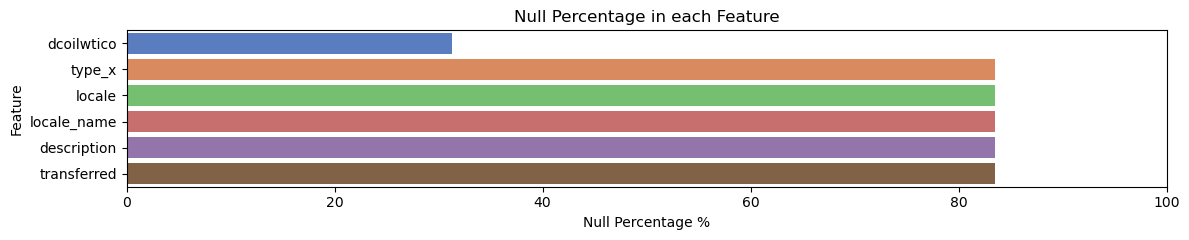

In [24]:
train_info = build_my_info_table(train_data)
nan_df = train_info[train_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature', xmin=0, xmax=100)

In [25]:
train_data = train_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))
test_data = test_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))

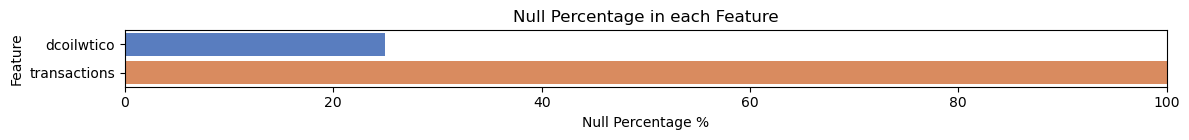

In [26]:
test_info = build_my_info_table(test_data)
nan_df = test_info[test_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature', xmin=0, xmax=100)

In [27]:
train_data = train_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))
test_data = test_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))

In [28]:
# replacing other na and inf values in the columns
def fill_na(df):
    num_feat = df.select_dtypes(include=[np.number]).columns
    cat_feat = df.select_dtypes(exclude=[np.number]).columns
    
    df[num_feat] = df[num_feat].fillna(df[num_feat].median())
    
    for col in cat_feat:
        df[col] = df[col].fillna(df[col].mode()[0])
    
def replace_inf(df):
    num_feat = df.select_dtypes(include=[np.number]).columns
    df[num_feat] = df[num_feat].replace([np.inf, -np.inf], np.nan)
    df[num_feat] = df[num_feat].fillna(df[num_feat].median())

In [29]:
replace_inf(train_data)
replace_inf(test_data)

fill_na(train_data)
fill_na(test_data)

In [30]:
# getting categorical and numerical features
def get_num(df, nunique_th=35):
    num_feat = df.select_dtypes(include=[np.number]).columns
    
    numerical_feat = [col for col in num_feat if df[col].nunique() >= nunique_th]
    
    return numerical_feat

def get_cat(df, nunique_th=35):
    cat_feat = [col for col in df.columns if df[col].nunique() < nunique_th]
    
    return cat_feat

In [31]:
categorical_features = get_cat(train_data)
numerical_features = get_num(train_data)

print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['family', 'city', 'state', 'type_y', 'cluster']
Numerical Features: ['store_nbr', 'sales', 'onpromotion', 'dcoilwtico']


### Visualizations

In [32]:
# different plots
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

def my_distplot(df, col, ax):
    sns.distplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

def my_kdeplot(df, col, ax):
    sns.kdeplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

In [33]:
# categorical plots
def my_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct="%1.1f%%")
    ax.set_title(f"Pie Chart of the column {col}")

def my_cnt_plot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f"Count plot of the column {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    
def my_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)

def my_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)

In [34]:
# Matrix plots
def my_heatmap(df, size, cmap, cbar_kwsm, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0,
               cbar_kws = cbar_kws, annot_kws={"size" : font_size})
    plt.title("Correlation Heatmap")
    plt.show()

In [35]:
# plotting the features
def plot_feat(df, cols, plots, width, height, n_col=1):
    plt_funcs = len(plots)
    
    fig = plt.figure(figsize=(sum(width), max(height)))
    gs = fig.add_gridspec(1, plt_funcs*n_col,
                          width_ratios=width, height_ratios=height)
    
    axes = [0]*(plt_funcs*n_col)
    
    for i in range(n_col):
        for j in range(plt_funcs):
            k = i*plt_funcs + j
            axes[k] = fig.add_subplot(gs[0, k])
            plots[j](df, cols[i], axes[k])
            axes[k].set_xlabel(cols[i])
            
    plt.tight_layout()
    plt.show()

def plot_features(df, plots, width, height, n_col=1):
    for i in range(0, len(df.columns), n_col):
        plot_feat(df, df.columns[i:i+n_col], plots, width, height, n_col)

In [36]:
def plt_num_feat(df, plts=[my_boxplot, my_violinplot, my_distplot],
                width = [2, 2, 12], height = [4], n_col = 1):
    plot_features(df, plts, width, height)
    
def plt_cat_feat(df, plts=[my_pie_chart, my_cnt_plot],
                width = [5, 11], height = [5], n_col = 1):
    plot_features(df, plts, width, height)

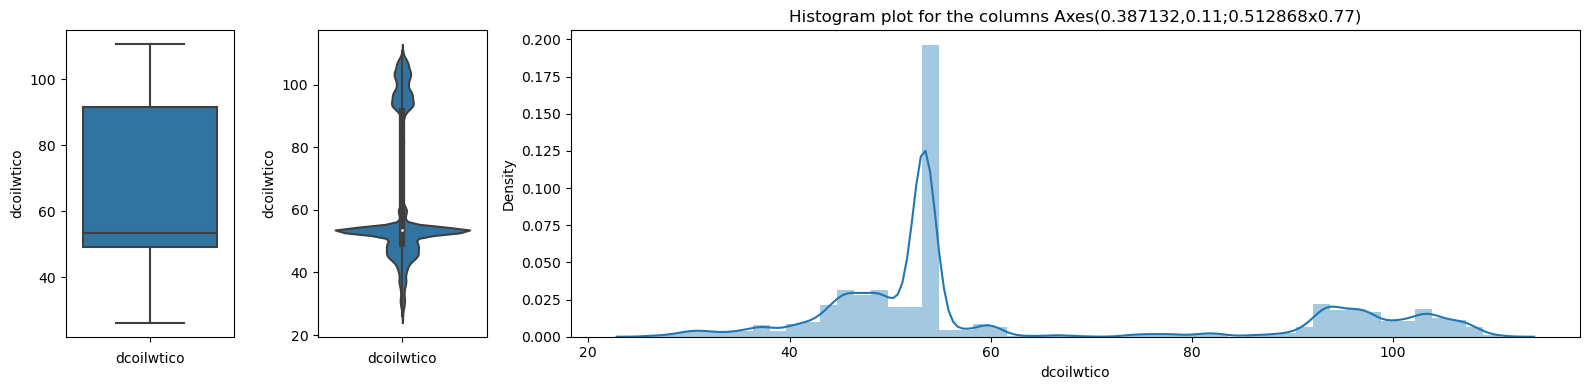

In [37]:
plt_num_feat(train_data[numerical_features[-1:]])

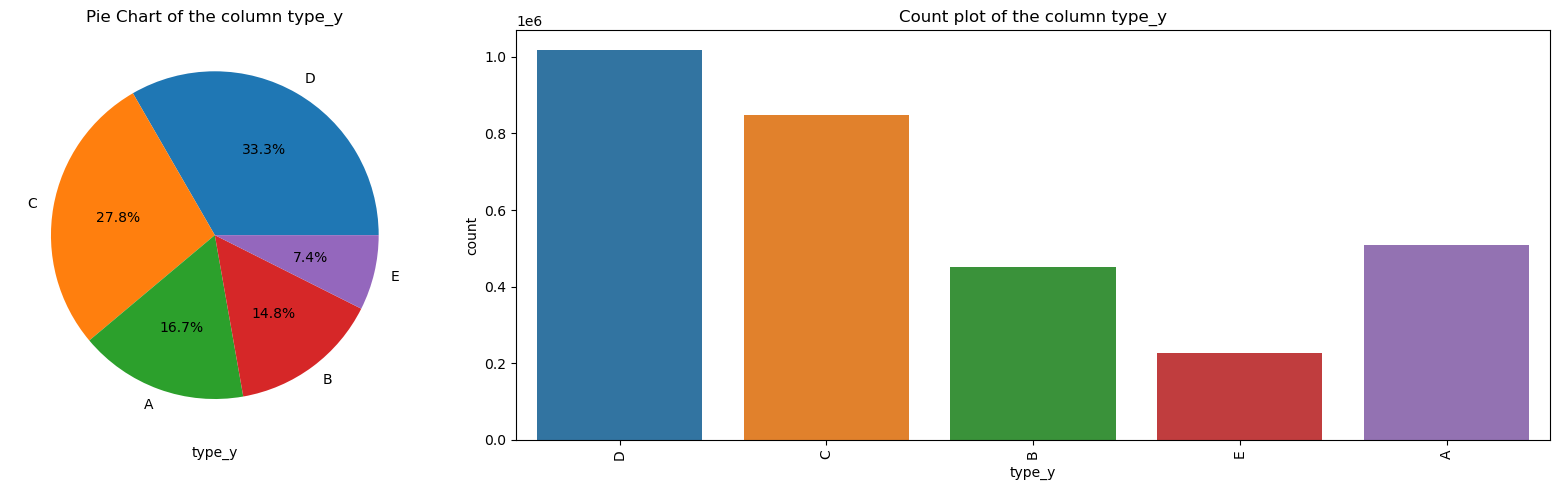

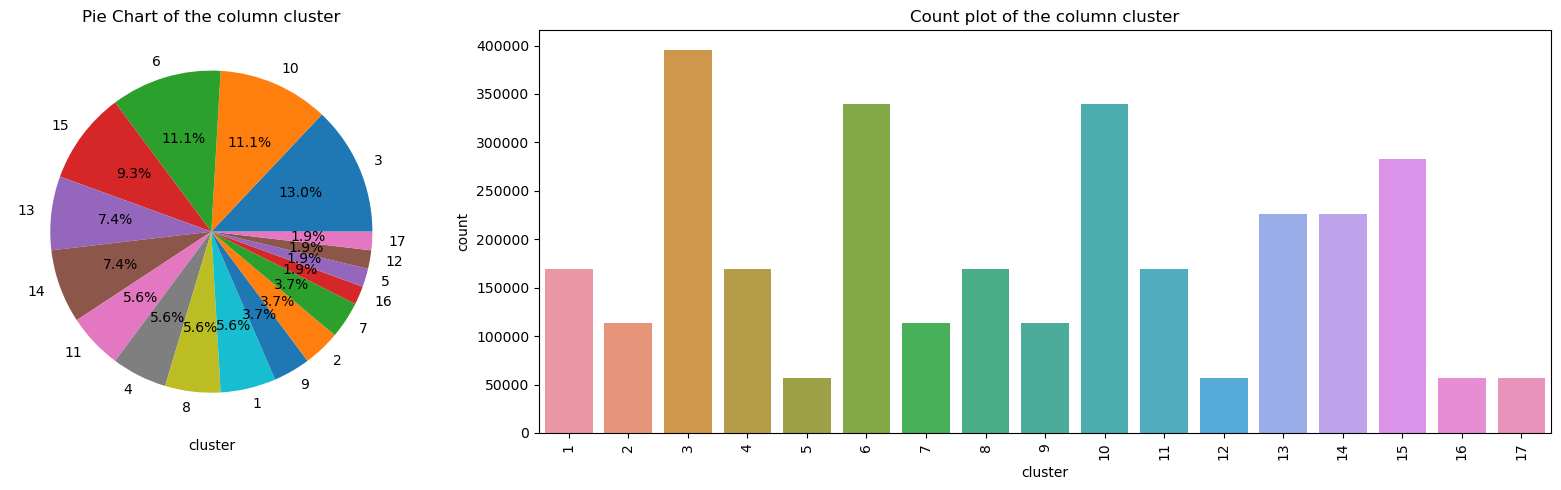

In [38]:
plt_cat_feat(train_data[categorical_features[-2:]])

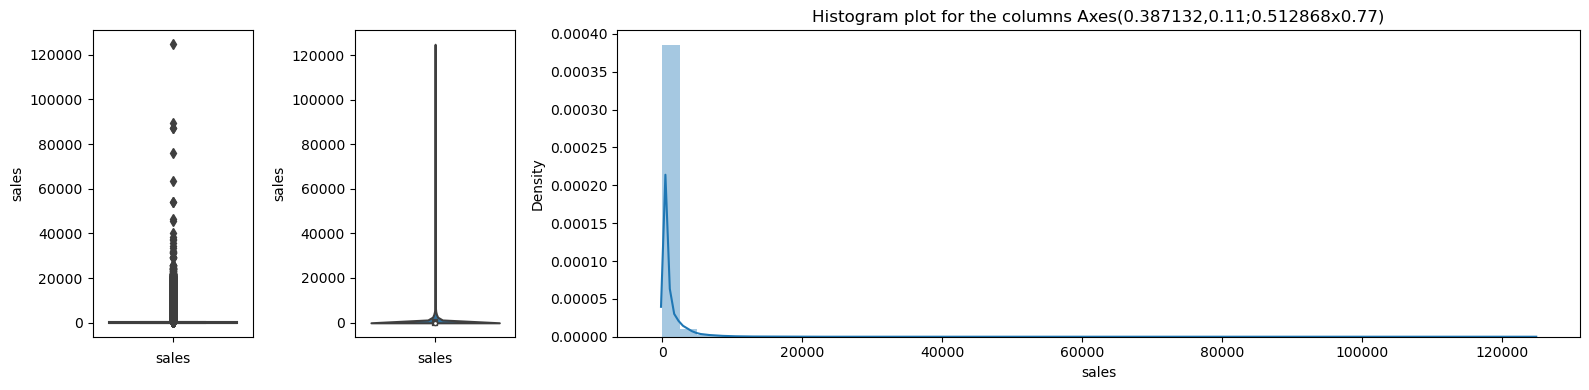

In [39]:
plt_num_feat(train_data[[target_feat]])

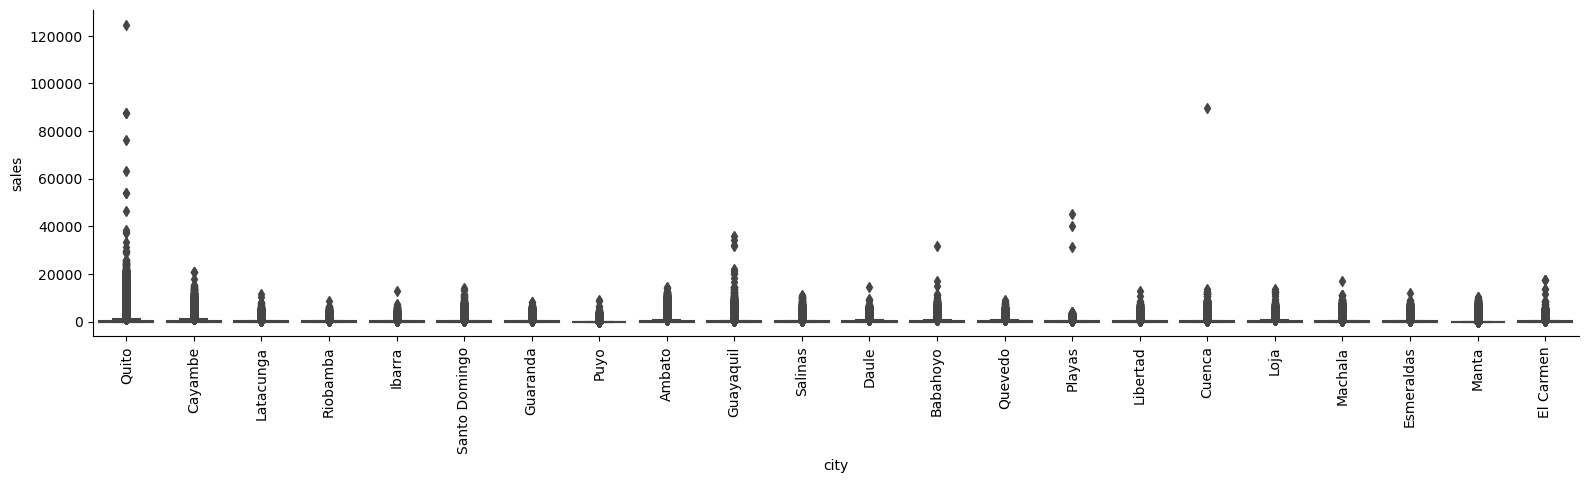

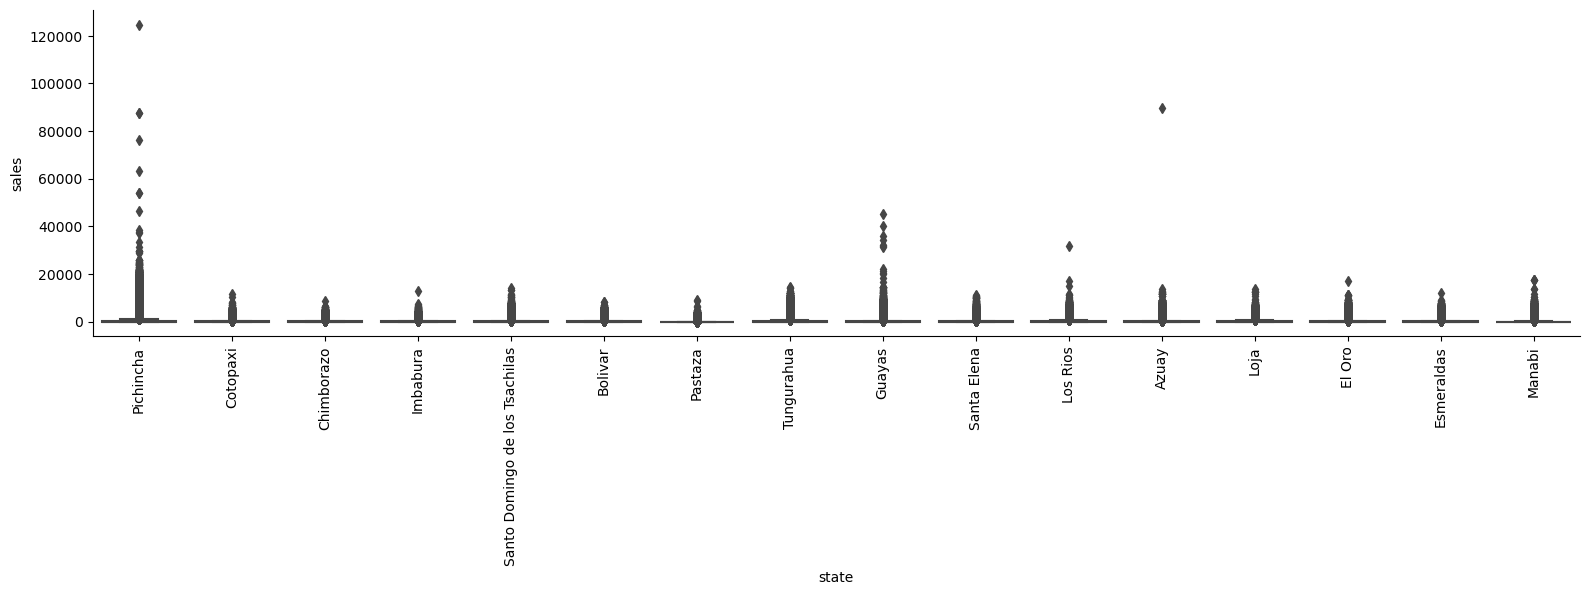

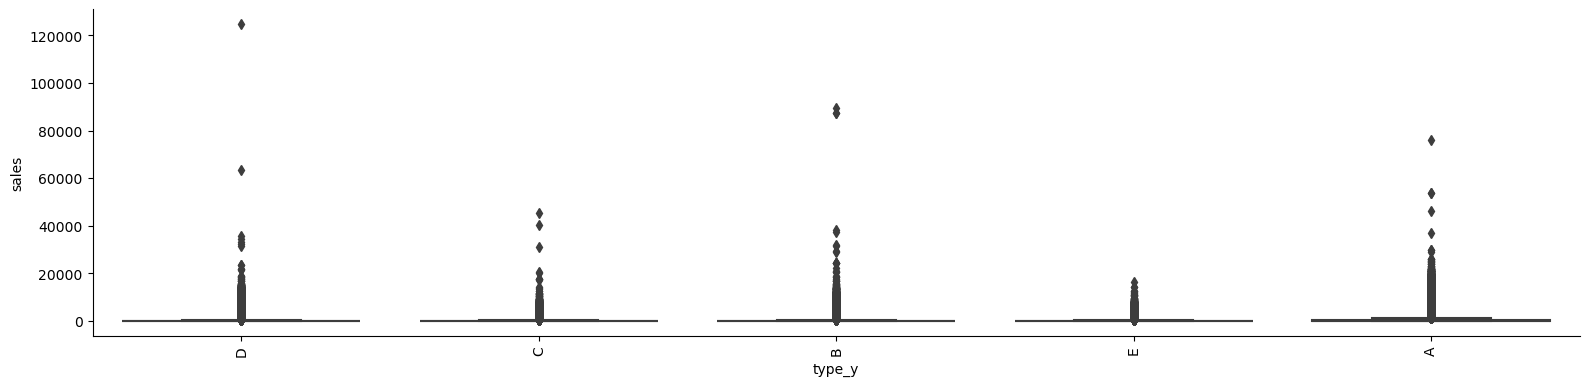

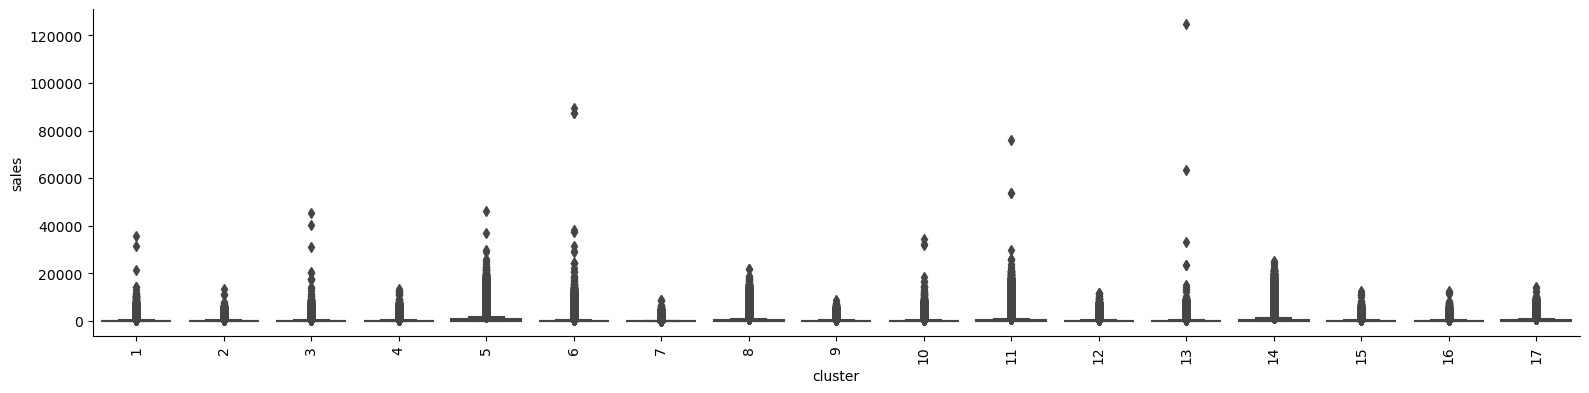

In [40]:
for cat in categorical_features[1:]:
    sns.catplot(data = train_data, x = cat, y = target_feat,
               kind='box', height=4, aspect=4)
    plt.xticks(rotation=90)
    plt.show()

In [41]:
def plt_correlation(df, feat, target, plts, step = 6,
                    height = 3, aspect = 1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(feat), step):
        for plt in plts:
            sns.pairplot(df, x_vars=feat[i:i+step], y_vars=[target],
                        kind=plt, height=height, aspect=aspect)

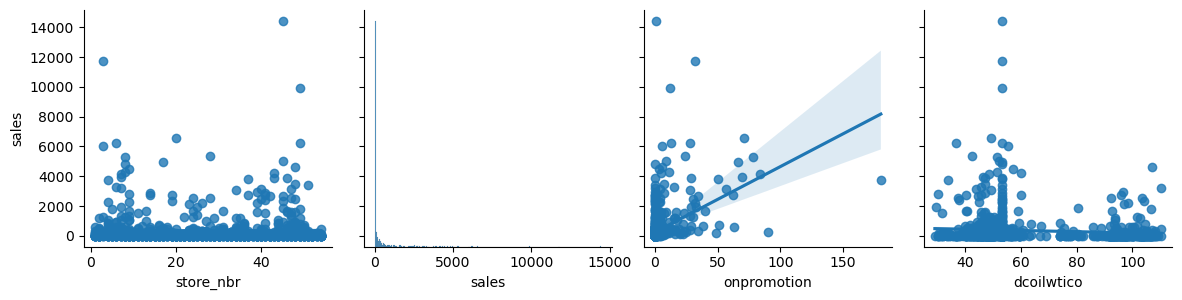

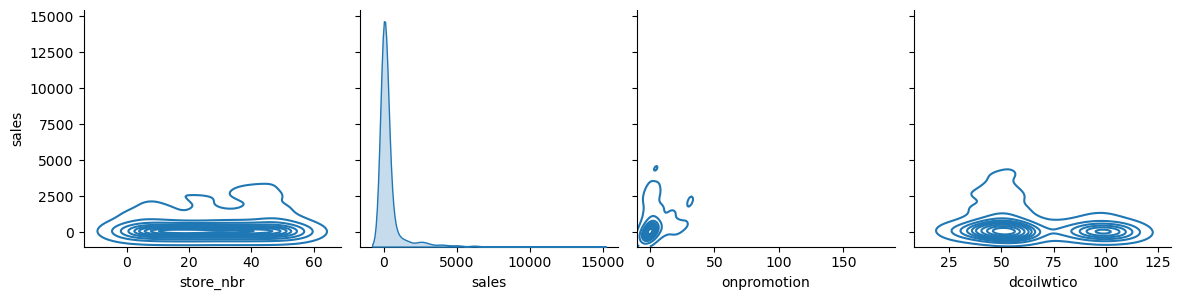

In [42]:
plt_correlation(train_data, numerical_features, target_feat,
               plts=['reg', 'kde'])

### Modeling

In [43]:
df_dtypes(train_data)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,2,"['sales', 'dcoilwtico']"
2,object,5,"['date', 'family', 'city', 'state', 'type_y']"


In [44]:
train_model = train_data.copy()
test_model  = test_data.copy()

In [45]:
def remove_col(df, col = "id"):
    if col not in df.columns:
        return df, None
    
    df_col = df[col]
    df = df.drop(columns=[col])
    
    return df, df_col

In [46]:
train_model, _ = remove_col(train_model)
test_model, _ = remove_col(test_model)

In [47]:
def encode_str_features(df):
    categorical_features = get_cat(df.select_dtypes(exclude=[np.number]))
    encoder = OrdinalEncoder()
    for col in categorical_features:
        df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1))

In [48]:
encode_str_features(train_model)
encode_str_features(test_model)
df_dtypes(train_model)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"
2,object,1,['date']


In [49]:
deleted_columns = list(train_model.select_dtypes(exclude=[np.number]).columns) + list(test_model.select_dtypes(exclude=[np.number]).columns)

deleted_columns = list(set(deleted_columns))

train_model = train_model.drop(columns=deleted_columns)
test_model  = test_model.drop(columns=deleted_columns)
df_dtypes(train_model)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"


In [50]:
def get_evaluation_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    meae = median_absolute_error(y_test, y_pred)
    me = max_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    
    return {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Mean Absolute Percentage Error': mape,
        'Median Absolute Error': meae,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': evs,
    }

In [51]:
baseline_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
#     'RandomForestRegressor':     RandomForestRegressor(),
#     'KNeighborsRegressor':       KNeighborsRegressor(),
}

In [52]:
def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = get_evaluation_metrics(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
        
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [53]:
def split_data_train_test(df, target_feature, test_size=0.2):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = split_data_train_test(train_model, target_feat)

In [55]:
models_result = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.01 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.17 minutes


In [56]:
models_result

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,426.962448,957603.573196,3.596174e+17,236.394109,84990.658061,0.199516,0.199519
1,Ridge,426.962446,957603.573162,3.596174e+17,236.394150,84990.658094,0.199516,0.199519
2,DecisionTreeRegressor,99.914248,209544.687369,2.639767e+16,6.000000,118412.000000,0.824837,0.824843


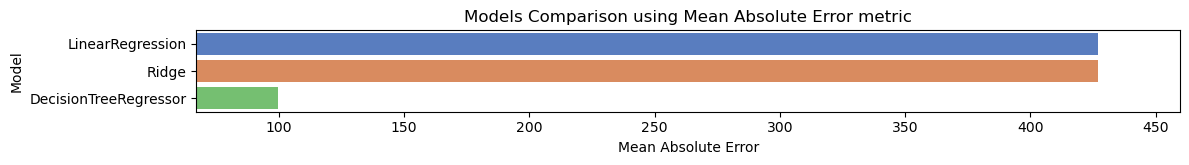

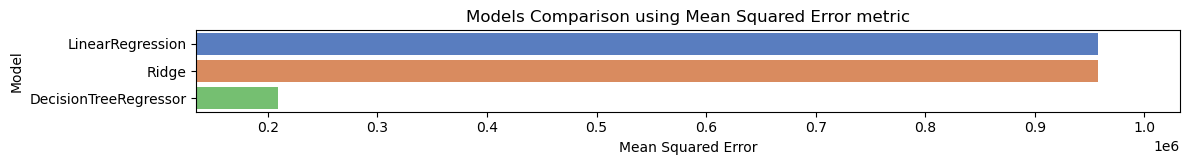

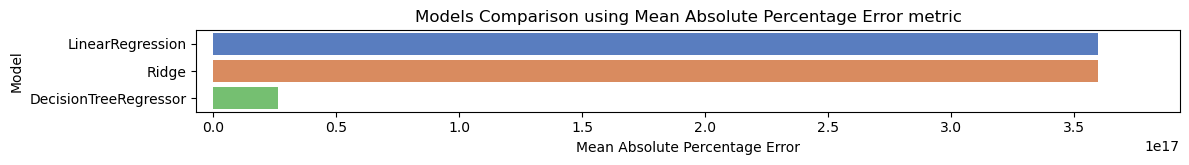

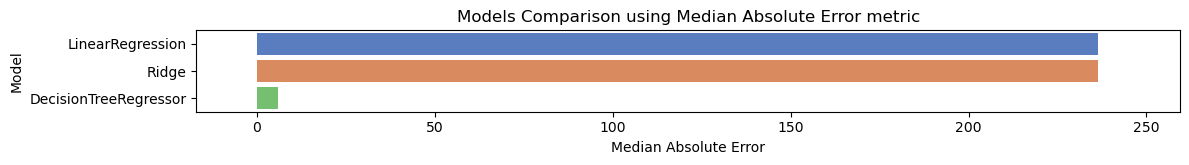

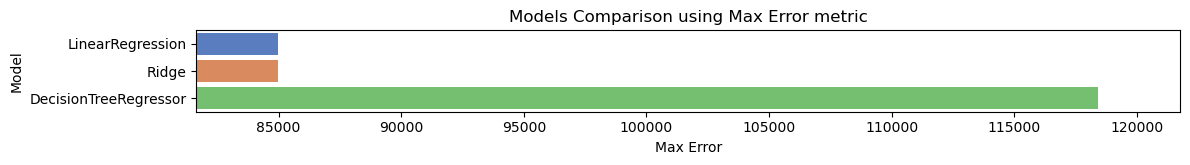

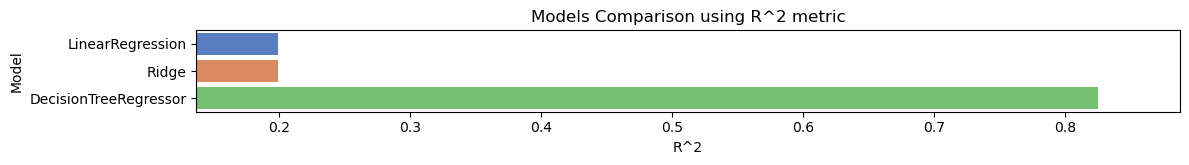

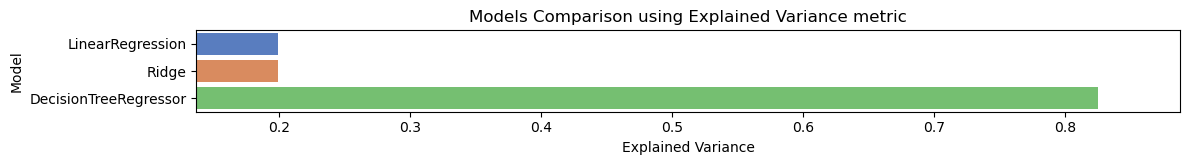

In [57]:
metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Mean Absolute Percentage Error', 'Median Absolute Error', 'Max Error', 'R^2', 'Explained Variance']

for metric in metrics:
    plot_bar_chart(models_result, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

### Feature Engineering

Skewed Data, Outlier Data, Imbalanced Data

In [58]:
train_data.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_y,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,53.43,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,53.43,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,53.43,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,53.43,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0,53.43,Quito,Pichincha,D,13


In [59]:
train_model_1 = train_data.copy()
test_model_1 = test_data.copy()

In [60]:
def get_date_features(df, col):
    df[col] = pd.to_datetime(df[col])
    df[f"{col} year"]           = df[col].dt.year.astype(int)
    df[f"{col} month"]          = df[col].dt.month.astype(int)
    df[f"{col} day"]            = df[col].dt.day.astype(int)
    df[f"{col} day of week"]    = df[col].dt.dayofweek.astype(int)
    df[f"{col} week of year"]   = df[col].dt.isocalendar().week.astype(int)
    df[f"{col} quarter"]        = df[col].dt.quarter.astype(int)
    df[f"{col} is weekend"]     = df[f'{col} day of week'].isin([5, 6]).astype(int)
    df[f"{col} is leap year"]   = df[col].dt.is_leap_year.astype(int)
    df[f"{col} is_month_end"]   = df[col].dt.is_month_end.astype(int)
    df[f"{col} is_month_start"] = df[col].dt.is_month_start.astype(int)

In [61]:
get_date_features(train_model_1, 'date')
get_date_features(test_model_1, 'date')
df_dtypes(train_model_1)

,dtype,Number of columns,columns
0,datetime64[ns],1,['date']
1,int64,13,"['store_nbr', 'onpromotion', 'cluster', 'date year', 'date month', 'date day', 'date day of week', 'date week of year', 'date quarter', 'date is weekend', 'date is leap year', 'date is_month_end', 'date is_month_start']"
2,float64,2,"['sales', 'dcoilwtico']"
3,object,4,"['family', 'city', 'state', 'type_y']"


In [62]:
encode_str_features(train_model_1)
encode_str_features(test_model_1)
df_dtypes(train_model_1)

,dtype,Number of columns,columns
0,datetime64[ns],1,['date']
1,int64,13,"['store_nbr', 'onpromotion', 'cluster', 'date year', 'date month', 'date day', 'date day of week', 'date week of year', 'date quarter', 'date is weekend', 'date is leap year', 'date is_month_end', 'date is_month_start']"
2,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"


In [63]:
def one_hot_encoding(df):
    categorical_features = get_cat(df.select_dtypes(include=[np.number]))
    if target_feat in categorical_features:
        categorical_features.remove(target_feat)
        
    encoder = OneHotEncoder(sparse = False, drop = "first")
    encoded_features = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=df.index)
    df = df.drop(columns=categorical_features)
    df = pd.concat([df, encoded_df], axis=1)
    print(encoded_df.head())
    return df

In [64]:
train_model_1 = train_model_1.drop(columns=train_model_1.select_dtypes(exclude=[np.number]).columns)
test_model_1 = test_model_1.drop(columns=test_model_1.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model_1)

,dtype,Number of columns,columns
0,int64,13,"['store_nbr', 'onpromotion', 'cluster', 'date year', 'date month', 'date day', 'date day of week', 'date week of year', 'date quarter', 'date is weekend', 'date is leap year', 'date is_month_end', 'date is_month_start']"
1,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"


In [65]:
def extract_skewed_data(df, th=0.25):
    num_features = get_num(df)
    skew_df = df[num_features].apply(lambda x : x.skew())
    skew_df = skew_df.sort_values(ascending=False)
    skew_df = skew_df.reset_index()
    skew_df.columns = ['Feature', 'SkewFactor']
    skewed_features = list(skew_df[abs(skew_df['SkewFactor']) > th]['Feature'])
    non_skewed_features = list(set(numerical_features)-set(skewed_features))
    return skewed_features, non_skewed_features, skew_df

In [66]:
skewed_features, non_skewed_features, skew_df = extract_skewed_data(train_model_1)
print(f'skewed_features:     {len(skewed_features)}\n{skewed_features}\n')
print(f'non_skewed_features: {len(non_skewed_features)}\n{non_skewed_features}\n')

skewed_features:     3
['onpromotion', 'sales', 'dcoilwtico']

non_skewed_features: 1
['store_nbr']



In [67]:
skew_df

,Feature,SkewFactor
0,onpromotion,11.299618
1,sales,7.499912
2,dcoilwtico,0.847462
3,date week of year,0.127567
4,store_nbr,0.000000


In [68]:
standardScaler = StandardScaler()

def transform_non_skewed_features(df, non_skewed_features):
    for col in non_skewed_features:
        df[col] = standardScaler.fit_transform(df[[col]])

def transform_skewed_features(df, skewed_features):
    for col in skewed_features:
        negative_indices = df[col] < 0
        df[col] = np.log1p(np.abs(df[col]))
        df[col] = np.where(negative_indices, -df[col], df[col])

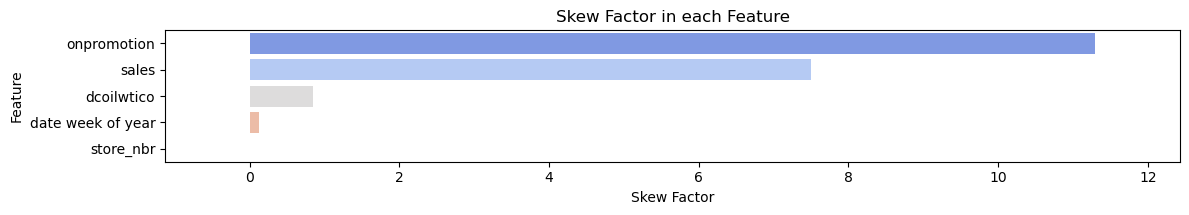

In [69]:
plot_bar_chart(skew_df, x='SkewFactor', y='Feature',
               xlabel='Skew Factor', ylabel='Feature', 
               title='Skew Factor in each Feature', palette='coolwarm')

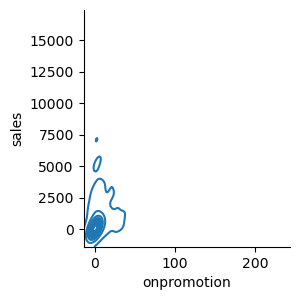

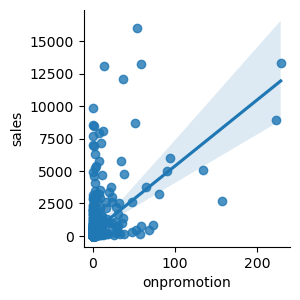

In [70]:
plt_correlation(train_model_1, skewed_features[:-2], 
                          target_feat, plts=['kde', 'reg'])

In [71]:
transform_skewed_features(train_model_1, skewed_features)

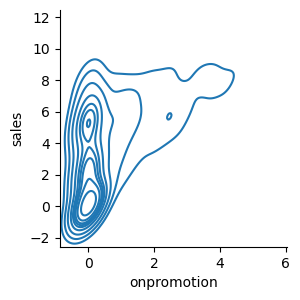

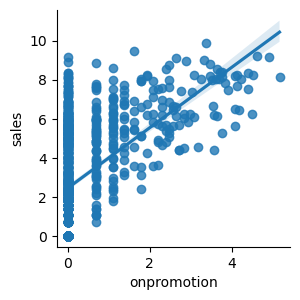

In [72]:
plt_correlation(train_model_1, skewed_features[:-2], 
                          target_feat, plts=['kde', 'reg'])

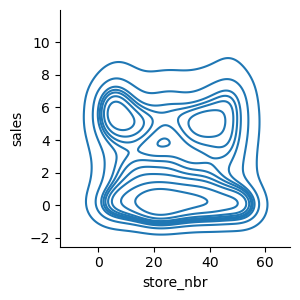

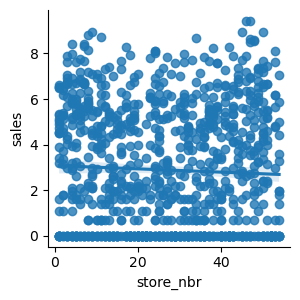

In [73]:
plt_correlation(train_model_1, non_skewed_features[:], 
                          target_feat, plts=['kde', 'reg'])

In [74]:
transform_non_skewed_features(train_model_1, non_skewed_features)

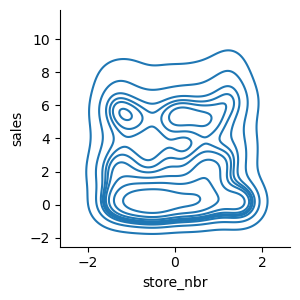

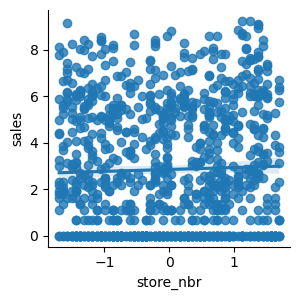

In [75]:
plt_correlation(train_model_1, non_skewed_features[:], 
                          target_feat, plts=['kde', 'reg'])

In [76]:
skewed_features, non_skewed_features, skew_df = extract_skewed_data(train_model_1)
print(f'skewed_features:     {len(skewed_features)}\n{skewed_features}\n')
print(f'non_skewed_features: {len(non_skewed_features)}\n{non_skewed_features}\n')

skewed_features:     3
['onpromotion', 'dcoilwtico', 'sales']

non_skewed_features: 1
['store_nbr']



In [77]:
skewed_features = [feature for feature in skewed_features if feature != 'sales']

In [78]:
transform_skewed_features(test_model_1, skewed_features)
transform_non_skewed_features(test_model_1, non_skewed_features)

### Checking the model performance

In [79]:
replace_inf(train_model_1)
replace_inf(test_model_1)
fill_na(train_model_1)
fill_na(test_model_1)

In [80]:
def split_data_X_y(df, target_feature):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

In [81]:
X, y = split_data_X_y(train_model_1, target_feat)

In [82]:
def feature_selection(X, y, mutual_info_method, top_n=10):
    mutual_info = mutual_info_method(X, y)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'ImportanceFactor': mutual_info
    })
    importance_df = pd.DataFrame(importance_df, columns=['Feature', 'ImportanceFactor'])
    importance_df = importance_df.sort_values(by='ImportanceFactor', ascending=False)
    importance_df = importance_df.head(top_n)
    return importance_df

In [83]:
%%time
importance_df = feature_selection(X, y, mutual_info_regression)

CPU times: user 9min 11s, sys: 2.74 s, total: 9min 14s
Wall time: 9min 25s


In [84]:
selected_features = importance_df['Feature']
X_selected  = X[selected_features]
test_model_1 = test_model_1[selected_features]
df_dtypes(X_selected)

,dtype,Number of columns,columns
0,int64,3,"['cluster', 'date year', 'date is leap year']"
1,float64,7,"['family', 'onpromotion', 'store_nbr', 'city', 'state', 'type_y', 'dcoilwtico']"


In [85]:
X_train_test_model_1 = pd.concat([X_selected, test_model_1])
X_train_test_model_1 = one_hot_encoding(X_train_test_model_1)
X_selected  = X_train_test_model_1[:len(X_selected)]
test_model_1 = X_train_test_model_1[-len(test_model_1):]
df_dtypes(X_selected)

   family_1.0  family_2.0  family_3.0  family_4.0  family_5.0  family_6.0  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         1.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         1.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         1.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         1.0         0.0         0.0   

   family_7.0  family_8.0  family_9.0  family_10.0  ...  state_15.0  \
0         0.0         0.0         0.0          0.0  ...         0.0   
1         0.0         0.0         0.0          0.0  ...         0.0   
2         0.0         0.0         0.0          0.0  ...         0.0   
3         0.0         0.0         0.0          0.0  ...         0.0   
4         0.0         0.0         0.0          0.0  ...         0.0   

   date year_2014  date year_2015  date year_2016  date year_2017  type_y_1.0  \
0             0.0            

,dtype,Number of columns,columns
0,float64,96,"['onpromotion', 'store_nbr', 'dcoilwtico', 'family_1.0', 'family_2.0', 'family_3.0', 'family_4.0', 'family_5.0', 'family_6.0', 'family_7.0', 'family_8.0', 'family_9.0', 'family_10.0', 'family_11.0', 'family_12.0', 'family_13.0', 'family_14.0', 'family_15.0', 'family_16.0', 'family_17.0', 'family_18.0', 'family_19.0', 'family_20.0', 'family_21.0', 'family_22.0', 'family_23.0', 'family_24.0', 'family_25.0', 'family_26.0', 'family_27.0', 'family_28.0', 'family_29.0', 'family_30.0', 'family_31.0', 'family_32.0', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'city_1.0', 'city_2.0', 'city_3.0', 'city_4.0', 'city_5.0', 'city_6.0', 'city_7.0', 'city_8.0', 'city_9.0', 'city_10.0', 'city_11.0', 'city_12.0', 'city_13.0', 'city_14.0', 'city_15.0', 'city_16.0', 'city_17.0', 'city_18.0', 'city_19.0', 'city_20.0', 'city_21.0', 'state_1.0', 'state_2.0', 'state_3.0', 'state_4.0', 'state_5.0', 'state_6.0', 'state_7.0', 'state_8.0', 'state_9.0', 'state_10.0', 'state_11.0', 'state_12.0', 'state_13.0', 'state_14.0', 'state_15.0', 'date year_2014', 'date year_2015', 'date year_2016', 'date year_2017', 'type_y_1.0', 'type_y_2.0', 'type_y_3.0', 'type_y_4.0', 'date is leap year_1']"


In [86]:
X_train_test_model_1

,onpromotion,store_nbr,dcoilwtico,family_1.0,family_2.0,family_3.0,family_4.0,family_5.0,family_6.0,family_7.0,...,state_15.0,date year_2014,date year_2015,date year_2016,date year_2017,type_y_1.0,type_y_2.0,type_y_3.0,type_y_4.0,date is leap year_1
0,0.000000,-1.700267,3.996915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,-1.700267,3.996915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-1.700267,3.996915,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,-1.700267,3.996915,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,-1.700267,3.996915,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,0.693147,-1.186979,3.876603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28508,0.000000,-1.186979,3.876603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28509,0.693147,-1.186979,3.876603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28510,2.302585,-1.186979,3.876603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [87]:
X_train, X_test, y_train, y_test = split_data_train_test(pd.concat([X_selected, y], axis=1), target_feat)

In [88]:
models_result_1 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.39 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.04 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.66 minutes


In [89]:
models_result_1

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,0.962988,1.749223,1.786542e+15,0.734609,8.126053,0.759090,0.759091
1,Ridge,0.962989,1.749217,1.786199e+15,0.734706,8.125950,0.759091,0.759092
2,DecisionTreeRegressor,0.392793,0.566461,3.932710e+14,0.182044,9.352603,0.921985,0.921985


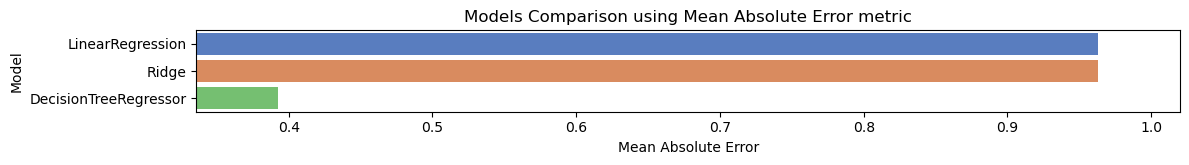

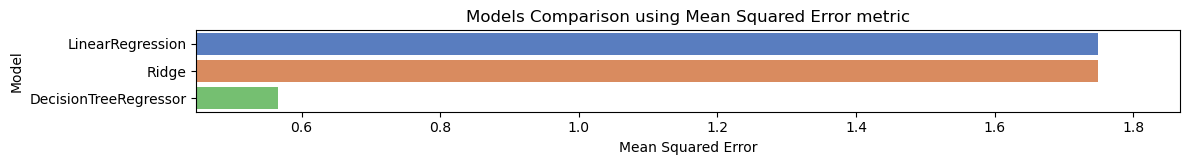

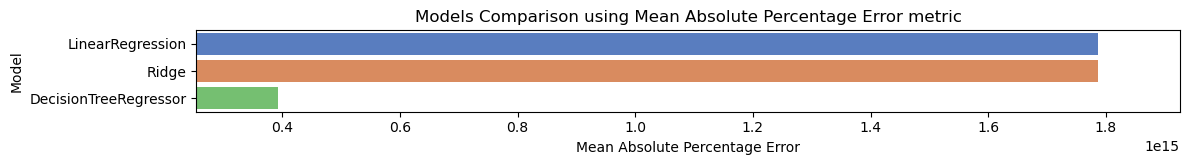

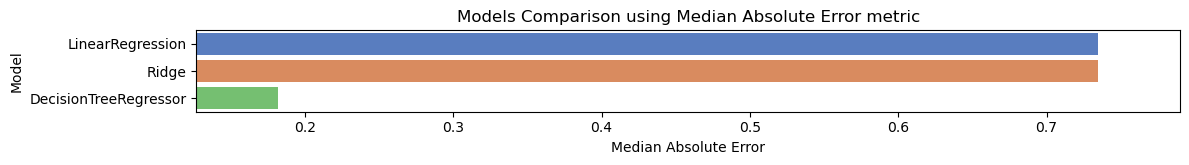

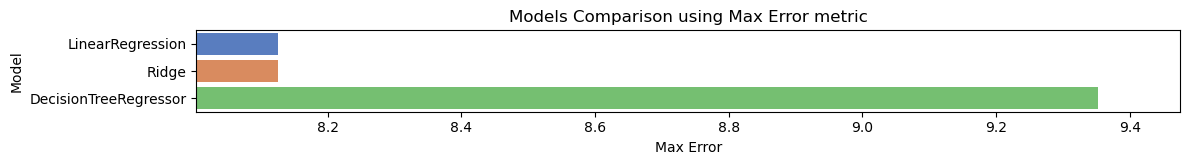

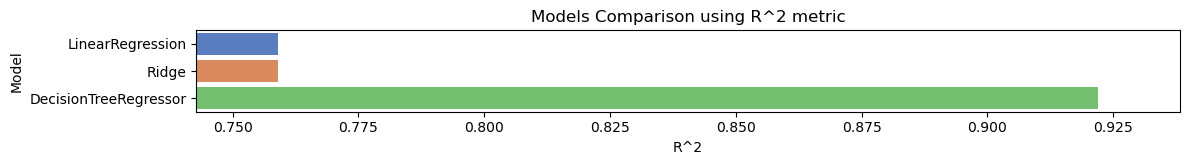

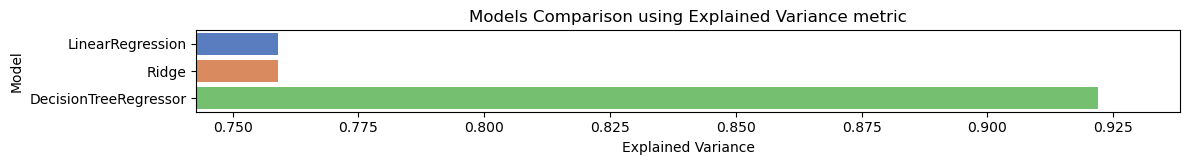

In [90]:
metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Mean Absolute Percentage Error', 'Median Absolute Error', 'Max Error', 'R^2', 'Explained Variance']

for metric in metrics:
    plot_bar_chart(models_result_1, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [91]:
decision_tree = DecisionTreeRegressor()

In [92]:
results = {}
begin_time = time.time()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
end_time = time.time()
duration = round((end_time - begin_time) / 60, 2)
print(f'Model run in'.ljust(50), f'{duration} minutes')

Model run in                                       0.66 minutes


### All Feature Engineering

In [99]:
final_train_model = train_data.copy()
final_test_model = test_data.copy()

In [101]:
df_dtypes(final_train_model)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,2,"['sales', 'dcoilwtico']"
2,object,5,"['date', 'family', 'city', 'state', 'type_y']"


In [102]:
get_date_features(final_train_model, 'date')
get_date_features(final_test_model, 'date')
df_dtypes(final_train_model)

,dtype,Number of columns,columns
0,datetime64[ns],1,['date']
1,int64,13,"['store_nbr', 'onpromotion', 'cluster', 'date year', 'date month', 'date day', 'date day of week', 'date week of year', 'date quarter', 'date is weekend', 'date is leap year', 'date is_month_end', 'date is_month_start']"
2,float64,2,"['sales', 'dcoilwtico']"
3,object,4,"['family', 'city', 'state', 'type_y']"


In [103]:
encode_str_features(final_train_model)
encode_str_features(final_test_model)
df_dtypes(final_train_model)

,dtype,Number of columns,columns
0,datetime64[ns],1,['date']
1,int64,13,"['store_nbr', 'onpromotion', 'cluster', 'date year', 'date month', 'date day', 'date day of week', 'date week of year', 'date quarter', 'date is weekend', 'date is leap year', 'date is_month_end', 'date is_month_start']"
2,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"


#### Outliers

In [104]:
def plt_outliers(df, plts, out_idx, out_mthds, x_col, y_col):
    for i in range(len(out_mthds)):
        fig, ax = plt.subplots(1, 2, figsize = (12*2, 4))
        ax[0].set_title("Original Data")
        ax[1].set_title(f"Data without Outliers of {y_col} using {outliers_methods[i].__name__}")
        plot_func(x=x_col, y=y_col, ax=ax[0], data=df)
        plot_func(x=x_col, y=y_col, ax=ax[1], data=df.drop(outliers_indices[i]))
        plt.tight_layout()
        plt.show()

### Predicting

In [93]:
test_model_1.head()

,onpromotion,store_nbr,dcoilwtico,family_1.0,family_2.0,family_3.0,family_4.0,family_5.0,family_6.0,family_7.0,...,state_15.0,date year_2014,date year_2015,date year_2016,date year_2017,type_y_1.0,type_y_2.0,type_y_3.0,type_y_4.0,date is leap year_1
0,0.000000,-1.700267,3.867026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,-1.700267,3.867026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.098612,-1.700267,3.867026,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3.044522,-1.700267,3.867026,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,-1.700267,3.867026,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [94]:
Y_test_pred = decision_tree.predict(test_model_1)

In [95]:
len(Y_test_pred)

28512

In [96]:
predictions_df = pd.DataFrame({'id': test_data['id'], 'sales': Y_test_pred})

In [97]:
predictions_df.to_csv("./store-sales-time-series-forecasting/submission.csv", index=False)